## ***Responsible AI - 2024***
### *Laboratorio 2 - OBJRECLAB*

--------------------

**NOMBRES**: Stefano Alberto

**APELLIDOS**: Aragoni Maldonado

**CARNE**: 20261

**FECHA**: 23/08/2024

**LINK**: https://github.com/stefanoaragoni/OBJRECLAB

--------------------

### **Instrucciones:**




Este laboratorio busca guiar a través del proceso de uso de SHAP (SHapley Additive exPlanations) para interpretar las decisiones tomadas por un modelo de aprendizaje profundo entrenado en el conjunto de datos CIFAR-10. Al final de este laboratorio, se espera generar visualizaciones de SHAP que revelen la influencia de las características de las imágenes en las predicciones del modelo.

-----------

#### *Importar Librerías*

Para comenzar, se importan las librerías necesarias para el desarrollo del laboratorio.

In [7]:
# --- Librerías ---
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import shap
import os
from ipywidgets import interact, IntSlider

# --- Configuración de TensorFlow y GPU ---
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.14.0
GPU is available


#### *Importar Datos*

Posteriormente, se importan los datos necesarios para el desarrollo del laboratorio. En este caso, se importa el conjunto de datos CIFAR-10. 

Asimismo, se estandarizan las imágenes para que los píxeles tengan valores entre 0 y 1. Finalmente, también se definen los nombres de las clases del conjunto de datos CIFAR-10.

170498071/170498071 [==============================] - 22s 0us/step


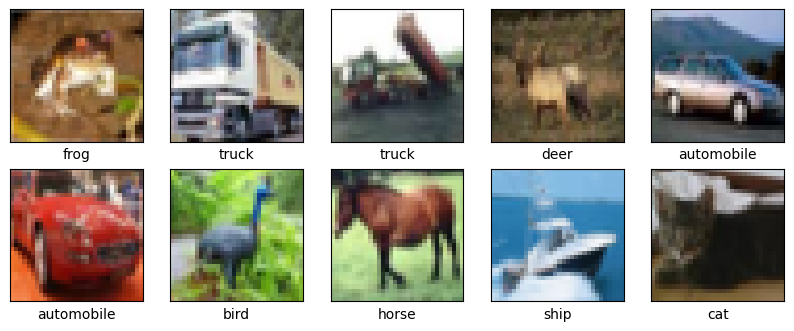

In [8]:
# --- Importar imágenes ---
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# --- Mostrar imágenes del dataset ---
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])

#### *Crear y entrenar el modelo*

Como tercer paso, se procede a crear un modelo de aprendizaje profundo que se entrenará con el conjunto de datos CIFAR-10. Este modelo se compone de una red neuronal convolucional (CNN) con 3 capas convolucionales y 2 capas densas.

Se utiliza la función de pérdida `sparse_categorical_crossentropy` y el optimizador `Adam` para compilar el modelo.

In [13]:
# --- Crear modelo de red neuronal convolucional ---
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Una vez definido el modelo, se procede a entrenarlo con el conjunto de datos CIFAR-10. Se entrena el modelo durante 10 épocas. 

Además, se procede a guardar el modelo entrenado en un archivo llamado `cifar10_model.h5`. En caso de que el modelo ya haya sido entrenado, se carga el modelo desde el archivo `cifar10_model.h5`.

In [14]:
# --- Entrenar modelo o cargar modelo pre-entrenado ---
model_path = 'cifar10_cnn.keras'

if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("No pre-trained model found. Training a new model...")
    model = create_model()
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))
    model.save(model_path)
    print(f"Model saved to {model_path}")

No pre-trained model found. Training a new model...
Epoch 1/10
1563/1563 [==============================] - 22s 13ms/step - loss: 2.8055 - accuracy: 0.3877 - val_loss: 3.4935 - val_accuracy: 0.3167
Epoch 2/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.2848 - accuracy: 0.4879 - val_loss: 2.5246 - val_accuracy: 0.4425
Epoch 3/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.1202 - accuracy: 0.5382 - val_loss: 2.3202 - val_accuracy: 0.5463
Epoch 4/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.1197 - accuracy: 0.5713 - val_loss: 8.5497 - val_accuracy: 0.2681
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 2.2149 - accuracy: 0.6002 - val_loss: 3.1624 - val_accuracy: 0.5127
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 2.2260 - accuracy: 0.6279 - val_loss: 2.2622 - val_accuracy: 0.6289
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - 

#### *Evaluación del Modelo*

Seguidamente, se evalúa el modelo entrenado con el conjunto de datos de prueba. Se calcula la precisión del modelo en el conjunto de datos de prueba.

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

313/313 - 1s - loss: 3.1939 - accuracy: 0.6840 - 1s/epoch - 4ms/step
Test accuracy: 0.68


Además, se desarrolló una función que selecciona aleatoriamente una imagen del conjunto de datos de prueba y la muestra junto con la predicción del modelo. Esto permite visualizar cómo el modelo clasifica una imagen específica.

1/1 [==============================] - 0s 298ms/step


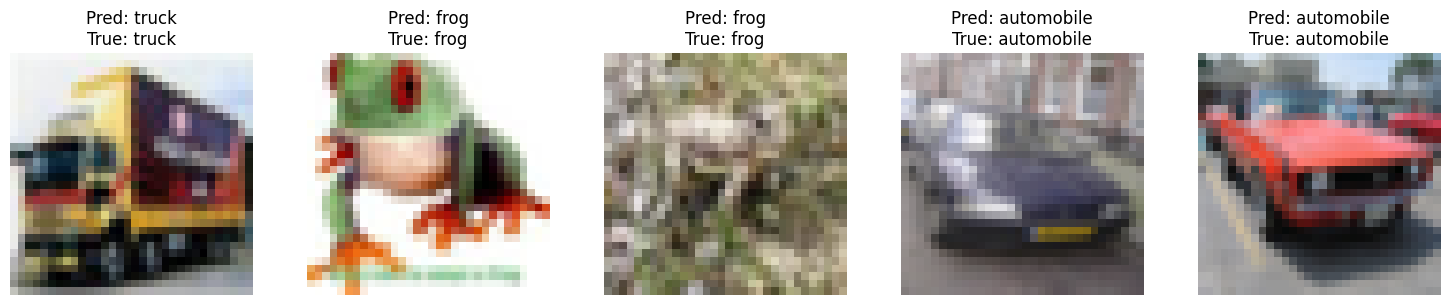

In [19]:
# --- Visualizar predicciones e imágenes ---
def test_model(model, test_images, test_labels, num_samples=5):
    indices = np.random.choice(test_images.shape[0], num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]

    predictions = model.predict(sample_images)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images[i])
        predicted_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[sample_labels[i][0]]
        ax.set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

test_model(model, test_images, test_labels)

-----------

#### *SHAP: Configuración*

Con lo anterior realizado, se procede a configurar SHAP para interpretar las decisiones del modelo de aprendizaje profundo. 

En este caso, se define un total de 100 imágenes de prueba para las cuales se calcularán los valores SHAP. Luego, se crea un objeto `explainer` de SHAP para el modelo entrenado junto con el conjunto reducido de datos de prueba.

In [25]:
# --- Imágenes de ejemplo para explicar ---
num_background = 100
background_images = test_images[:num_background]

# --- SHAP Gradient Explainer ---
explainer = shap.GradientExplainer(model, background_images)

#### *SHAP: Función para visualización*

Posteriormente, se define una función que permite visualizar los valores SHAP de una imagen específica. Esta función recibe como parámetro el índice de la imagen en el conjunto de datos de prueba y muestra la imagen, la predicción del modelo y los valores SHAP de cada píxel.

Esto, obviamente, permite visualizar cómo cada píxel de la imagen influye en la predicción del modelo. Un valor más alto de SHAP indica que el píxel contribuye más a la predicción específica, mientras que un valor más bajo indica que el píxel contribuye menos.

In [26]:
# --- Visualización de SHAP ---
def shap_visualization(image_index):
    image = test_images[image_index:image_index+1]
    true_label = test_labels[image_index][0]

    # Generate and process SHAP values
    shap_values = explainer.shap_values(image)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    shap_values_for_class = shap_values[0, ..., predicted_class]
    shap_sum = np.sum(shap_values_for_class, axis=-1)

    # Normalize SHAP values for scatter plot
    shap_normalized = (shap_sum - shap_sum.min()) / (shap_sum.max() - shap_sum.min())

    # Create figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axs[0].imshow(image[0])
    axs[0].set_title("Original Image\nTrue: " + class_names[true_label])
    axs[0].axis('off')

    # Scatter Plot with Stars on Image
    y, x = np.indices(shap_sum.shape)
    colors = shap_sum.flatten()  # Color by SHAP values
    sizes = 100 * shap_normalized.flatten() + 10  # Size of stars
    axs[1].imshow(image[0], aspect='auto')  # Display the original image as background
    scatter = axs[1].scatter(x.flatten(), y.flatten(), c=colors, s=sizes, cmap='coolwarm', marker='o', alpha=0.6)
    axs[1].set_title("SHAP Scatter on Image\nPredicted: " + class_names[predicted_class])
    axs[1].axis('off')
    fig.colorbar(scatter, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

#### *SHAP: Pruebas de imágenes*

Por último, se seleccionan 5 imágenes del conjunto de datos de prueba y se visualizan los valores SHAP de cada una de ellas. Esto permite observar cómo cada píxel de las imágenes influye en la predicción del modelo.

1/1 [==============================] - 0s 11ms/step


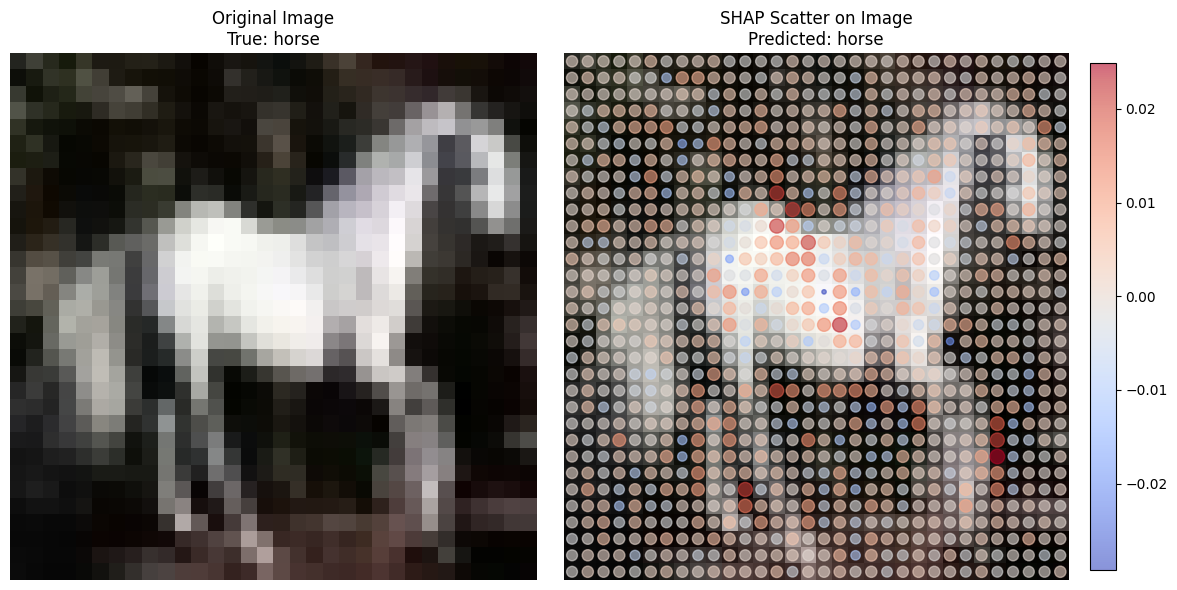

In [36]:
shap_visualization(13) 

1/1 [==============================] - 0s 10ms/step


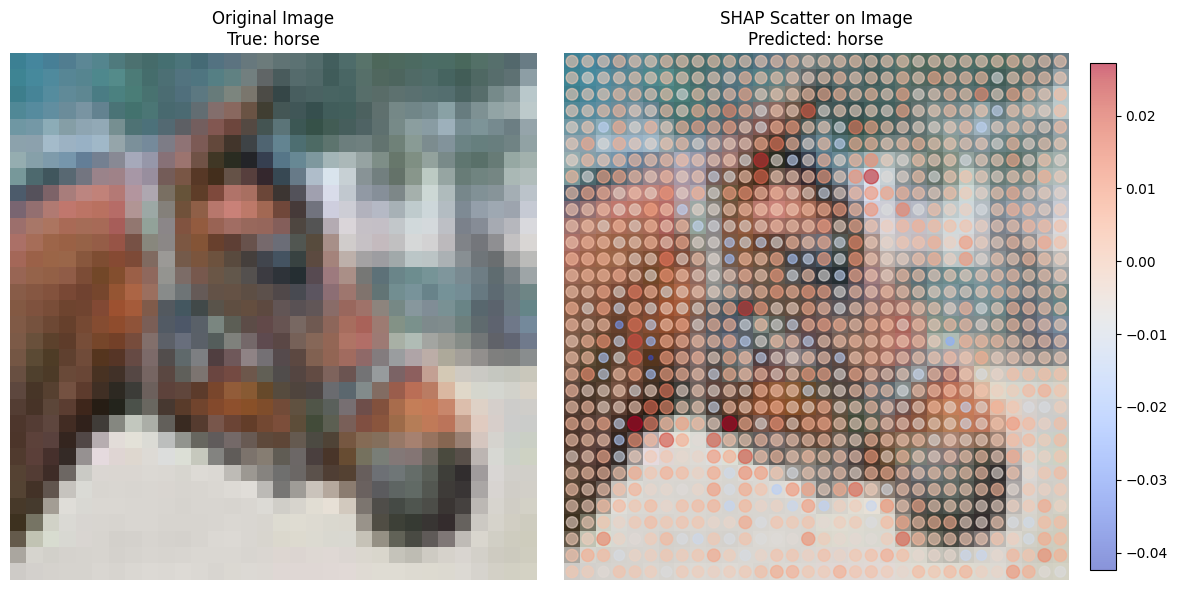

In [37]:
shap_visualization(17) 

1/1 [==============================] - 0s 12ms/step


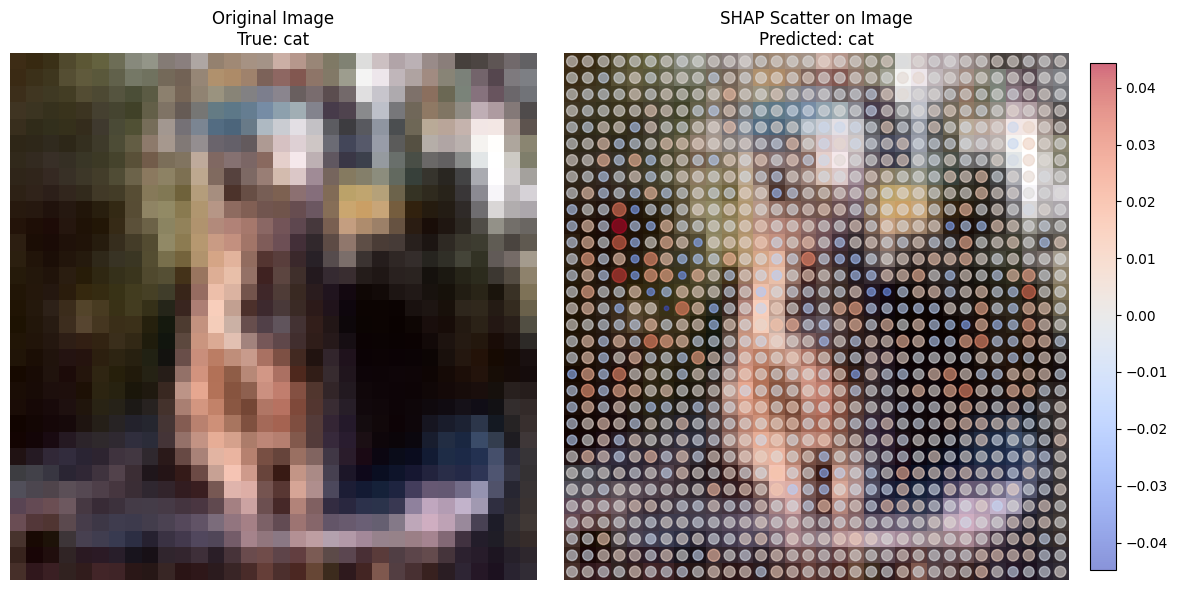

In [55]:
shap_visualization(68) 

1/1 [==============================] - 0s 11ms/step


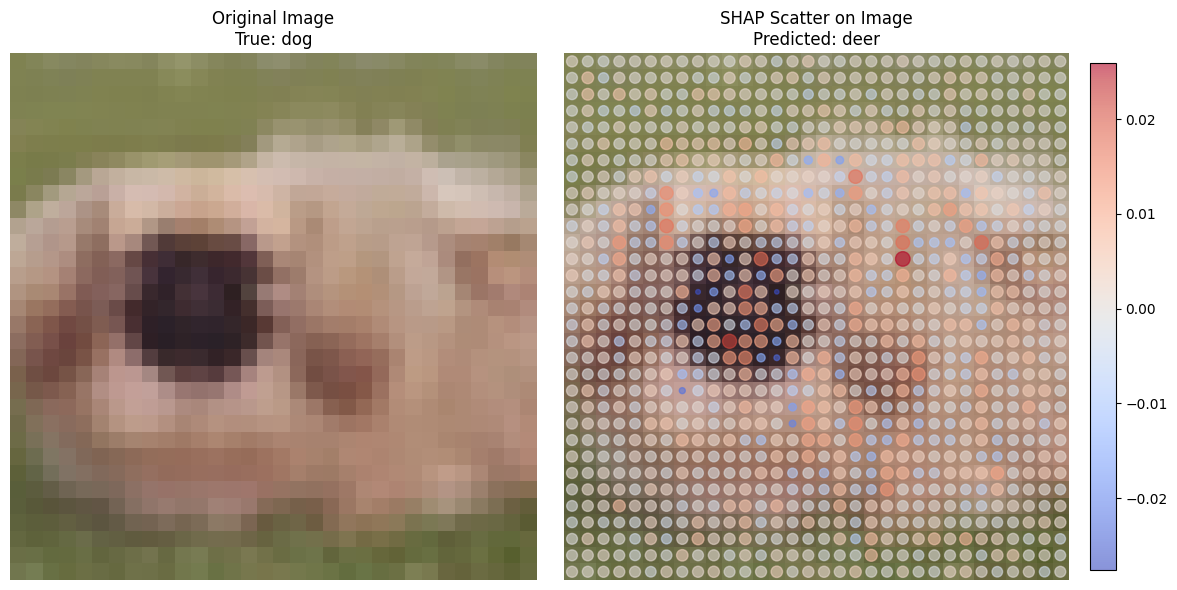

In [34]:
shap_visualization(31) 

In [ ]:
shap_visualization(3) 

-----------

#### *Conclusiones*